# Setup

In [1]:
!nvidia-smi
!python --version

Fri Jun 28 16:06:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             24W /  350W |    1130MiB /  12288MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Deep learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchmetrics.image import StructuralSimilarityIndexMeasure

#Data Science
import pandas as pd
from scipy.stats import ttest_rel

#visualization packages
import matplotlib.pyplot as plt # for plotting

#util
import os
from prettytable import PrettyTable
import tqdm
from tkinter import filedialog
import tkinter as tk
import numpy as np # for transformation
import time

#Image manipulation
import skimage
from skimage.restoration import denoise_nl_means, estimate_sigma

In [3]:
#set the device to cuda:0 - change if you desire to use another device/cpu
if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

print(device)

cuda:0


In [4]:
#model training parameters
training_params = {"epochs": 30, "batch_size": 64, "learning_rates_to_try": [0.0001]}
### CHANGE THIS TO MODIFY THE TRAINING PARAMETERS OF THE MODEL

# Load Data

In [5]:
#create the dataset class
#Load In the Dataset
class MRI_Dataset(Dataset):

  def __init__(self, data_path, flip=True, flip_prob=0.1, diagnostics=False):
    """
        Args:
            data_path (string): Directory with the training data. The data will already be normalized
    """
    #get list of data file names
    files = os.listdir(data_path)
    self.data_path = data_path
    self.real_files = [x for x in files if 'data_normalized' in x]
    if diagnostics == True:
      print('there are this many files in the list of data ', len(self.real_files))

    self.slice_list = []
    loaded_tensors = None
    torch.cuda.empty_cache()

    #define the l-r flip transform for data augmentation
    if flip == True:
      transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=flip_prob)])
    else:
      transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.0)])

    #take that list and expand it based on each "real_file" N size. normalized_data_0.pt -> normalized_data_0_1, normalized_data_0_2...
    if diagnostics == True:
      for file in tqdm.tqdm(self.real_files):

        #load in a single file (takes 15 seconds per file)
        loaded_tensors = torch.load(data_path +file) #loaded tensors will be N X 256 X 256
        N, _, _ = loaded_tensors.size()

        #divide up the tensor between slices and append each one to the master list
        for i in range(N):
          #self.slice_list.append(loaded_tensors[N-1,:,:]) #this is just repeating the last slice N times
          self.slice_list.append(transform(loaded_tensors[i,:,:]))

    else:
      #same as above just without tqdm to declutter the output
      for file in (self.real_files):

        loaded_tensors = torch.load(data_path +file)
        N, _, _ = loaded_tensors.size()

        for i in range(N):

          self.slice_list.append(transform(loaded_tensors[i,:,:]))

      #insert this break if you want to only load a single file in just a few secs instead of 7 minutes for the whole thing
      #break

  #this is a required function that tells you how many data points you have in the dataset
  def __len__(self):
      return len(self.slice_list)

  #this is a required function that allows you to obtain a single data point according to its index
  def __getitem__(self, idx):

    #we have self.slice_list containing: e.g. data_normalized_1_2961.pt
    MRI_image = self.slice_list[idx]

    return MRI_image

In [6]:
def tkinter_gui(flavour_text):
    """
    This function creates a Tkinter window for browsing directories and returns the selected directory path.

    Parameters
    ----------
    flavour_text : str
        A string to display in the Tkinter window.

    Returns
    -------
    selected_directory : str
        The selected directory path.

    Examples
    --------
    >>> selected_directory = tkinter_gui("Select a directory")
    """
    
    def browse_directory():
        directory_path = filedialog.askdirectory()
        if directory_path:
            nonlocal selected_directory
            selected_directory = directory_path
            root.destroy()  # Close the Tkinter window

    # Create the main window
    root = tk.Tk()
    root.title("Directory Browser")

    # Create a label and button to display selected directory and browse
    directory_label = tk.Label(root, text=flavour_text, padx=10, pady=10)
    directory_label.pack()
    browse_button = tk.Button(root, text="Browse", command=browse_directory)
    browse_button.pack()

    # Run the application
    selected_directory = None  # Initialize selected_directory variable
    root.mainloop()
    if selected_directory:
        return selected_directory   
    else:
        raise ValueError("No directory selected")
    
    return

In [7]:
#try the dataset creator
torch.cuda.empty_cache()

dec = input("Do you want to run the dataloader as a test? (y/n) ")
if dec.lower == "y":
  datapath = tkinter_gui("Select the directory containing the a partition of testdata")
  MRI_dataset = MRI_Dataset(data_path=datapath, diagnostics=True) ### format e.g. "C:\\Users\\miker\\Downloads\\IXI-T1\\testdir\\"
  MRI_dataloader = DataLoader(MRI_dataset, batch_size=76, shuffle=True, drop_last=False) #TEMPORARILY SET DROP_LAST TO FALSE, CHANGE LATER

  del dec, datapath

# Noise generation and utilities

In [8]:
def gaussian_noise_gen(input_tensor, mode="train", fixed_sigma=5):
    """
    This function adds random gaussian noise to an input image tensor and returns a new tensor.

    Parameters
    ----------
    input_tensor : torch.Tensor
        A tensor representing an image.
    mode : str
        A string that determines whether the noise sigma is randomly generated or fixed.
    fixed_sigma : int
        An integer that determines the fixed noise sigma to use in percent if mode is set to "fixed".

    Returns
    -------
    tensor_to_return : torch.Tensor
        A tensor representing the noised image.

    Examples
    --------
    >>> input_tensor = torch.rand(1, 256, 256) # a random grayscale image
    >>> noised_tensor = noise_gen(input_tensor) # add noise to the image
    >>> noised_tensor.shape
    torch.Size([1, 256, 256])
    """
    global device
    
    # Convert the input tensor to a numpy array and handle any NaN values
    try:
        input_tensor = input_tensor.cpu().numpy()
        input_tensor = np.nan_to_num(input_tensor)
    except:
        input_tensor = input_tensor.cpu().detach().numpy()
        input_tensor = np.nan_to_num(input_tensor)

    # Randomly generate the noise sigma - 1% to 20% of the max value of the image as per Manjon et al, 2018
    if mode == "train":
        noise_thresholds = [0.01, 0.03, 0.05, 0.07, 0.09]
    elif mode == "fixed":
        if fixed_sigma == 5:
            noise_thresholds = [0.05]
        elif fixed_sigma == 1:
            noise_thresholds = [0.01]
        elif fixed_sigma == 3:
            noise_thresholds = [0.03]
        elif fixed_sigma == 7:
            noise_thresholds = [0.07]
        elif fixed_sigma == 9:
            noise_thresholds = [0.09]
    stddev = np.random.choice(noise_thresholds, size=None, replace=True) * np.max(input_tensor) #max should be 1 so this is theoretically useless

    # Generate the noise and add it to the image
    noise = np.random.normal(0, stddev, input_tensor.shape).astype(np.float32)
    noised_img = (input_tensor + noise).astype(np.float32)
    del input_tensor
    
    return torch.tensor(noised_img).to(device).float(), torch.tensor(noise).to(device).float()


def rician_noise_gen(input_tensor_real, input_tensor_imag):
    """
    This function adds random rician noise to an input image tensor and returns a new tensor.
    Nonfunctional unless raw signal data is provided alongside patient scans.

    Parameters
    ----------
    input_tensor : torch.Tensor
        A tensor representing an image.
    input_tensor_imag : torch.Tensor
        A tensor representing the imaginary part of the image.

    Returns
    -------
    tensor_to_return : torch.Tensor
        A tensor representing the noised image.

    Examples
    --------
    >>> input_tensor = torch.rand(1, 256, 256) # a random grayscale image
    >>> noised_tensor = rician_noise_gen(input_tensor) # add noise to the image
    >>> noised_tensor.shape
    torch.Size([1, 256, 256])
    """
    global device

    try:
        tensor_np = input_tensor_real.cpu().numpy()
        tensor_np = np.nan_to_num(tensor_np)
        tensor_i_np = input_tensor_imag.cpu().numpy()
        tensor_i_np = np.nan_to_num(tensor_i_np)
    except:
        tensor_np = input_tensor_real.cpu().detach().numpy()
        tensor_np = np.nan_to_num(tensor_np)
        tensor_i_np = input_tensor_imag.cpu().detach().numpy()
        tensor_i_np = np.nan_to_num(tensor_i_np)

    N = tensor_np.size  # how many samples
    
    # Randomly generate the noise sigma - 1% to 9% of the max value of the image
    noise_thresholds = [0.01, 0.03, 0.05, 0.07, 0.09]
    s = np.random.choice(noise_thresholds, size=None, replace=True) * np.max(tensor_np) #max should be 1 so this is theoretically useless

    noise_real = np.random.normal(0, s, tensor_np.shape)
    noise_imag = np.random.normal(0, s, tensor_np.shape)

    # Create a complex noise signal
    noise_complex = noise_real + 1j*noise_imag

    # Add the noise to the original image (assuming the image is real-valued)
    noised_img = np.abs(tensor_np + noise_complex)
    del tensor_np, noise_real, noise_imag, noise_complex

    return (torch.tensor(noised_img).to(device)).float()

In [9]:
#test addition of noise to training dataset - visualize what noise looks like
noise_dec = input("Would you like to add Gaussian noise as a test - dataloader needs to have been initialized for this to work (y/n): ")
if noise_dec.lower() == "y":
  for i in range(len(MRI_dataloader)):
    sample = next(iter(MRI_dataloader))  

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(sample[75].cpu().data.numpy(), cmap = "gray")
    ax1.set_title("Original image")

    single_image_noised = gaussian_noise_gen(sample)[0]
    ax2.imshow(single_image_noised[75].cpu().data.numpy(), cmap = "gray")
    ax2.set_title("Noisy image")

    plt.show()

    print("PSNR ratio of original image: inf") #should be inf, higher PSNR is better and we haven't changed anything here
    print("PSNR ratio of noisy image: ", skimage.metrics.peak_signal_noise_ratio(sample[75].cpu().data.numpy(), single_image_noised[75].cpu().data.numpy())) #should be low due to additive noise
    if i > 5:
      break

# Network

In [10]:
#block architectures
class downsample_block_new(nn.Module):
  def __init__(self, dims, kernel_size = 3, stride=2, num_channels_in=1, num_channels_out=1):
        super(downsample_block_new, self).__init__()

        self.lrelu = nn.LeakyReLU()
        self.dims = dims


        self.conv_down1 = nn.Conv2d(num_channels_in, num_channels_out, stride=stride, kernel_size = kernel_size, padding=kernel_size-3, padding_mode='reflect')
        self.bn_down1 = nn.BatchNorm2d(num_channels_out)
        self.conv_down2 = nn.Conv2d(num_channels_out, num_channels_out, kernel_size = kernel_size, padding = "same")
        self.bn_down2 = nn.BatchNorm2d(num_channels_out)


  def forward(self, x):

        x = self.conv_down1(x)
        x = self.lrelu(self.bn_down1(x))
        x = self.conv_down2(x)
        x = self.lrelu(self.bn_down2(x))

        return x
  


class downsample_block_new_2(nn.Module):
  def __init__(self, dims, kernel_size = 3, stride=2, num_channels_in=1, num_channels_out=1):
        super(downsample_block_new_2, self).__init__()

        self.lrelu = nn.LeakyReLU()
        self.dims = dims


        self.conv_down1 = nn.Conv2d(num_channels_in, num_channels_out, stride=stride, kernel_size = kernel_size, padding=kernel_size-2, padding_mode='reflect')
        self.bn_down1 = nn.BatchNorm2d(num_channels_out)
        self.conv_down2 = nn.Conv2d(num_channels_out, num_channels_out, kernel_size = kernel_size, padding = "same")
        self.bn_down2 = nn.BatchNorm2d(num_channels_out)


  def forward(self, x):

        x = self.conv_down1(x)
        x = self.lrelu(self.bn_down1(x))
        x = self.conv_down2(x)
        x = self.lrelu(self.bn_down2(x))

        return x


class upsample_block_new(nn.Module):
  def __init__(self, dims, kernel_size = 5, padding_ = "same", num_channels_in=1, num_channels_out=1):
        super(upsample_block_new, self).__init__()

        self.lrelu = nn.LeakyReLU()
        self.dims = dims

        self.bn1 = nn.BatchNorm2d(num_channels_in)
        self.conv_up1 = nn.Conv2d(num_channels_in, num_channels_out, kernel_size = kernel_size, padding = padding_)
        self.bn_up1 = nn.BatchNorm2d(num_channels_out)
        self.lrelu = nn.LeakyReLU()
        self.conv_up2 = nn.Conv2d(num_channels_out, num_channels_out, kernel_size = kernel_size, padding = padding_)
        self.bn_up2 = nn.BatchNorm2d(num_channels_out)

  def forward(self, x):

        x = self.bn1(x)
        x = self.conv_up1(x)
        x = self.lrelu(self.bn_up1(x))
        x = self.conv_up2(x)
        x = self.bn_up2(x)
        x = nn.functional.interpolate(x, size = self.dims, mode='bilinear', align_corners=True)

        return x


class midblock_new(nn.Module):
  def __init__(self, kernel_size = 3, padding_ = "same", num_channels=1):
        super(midblock_new, self).__init__()

        self.midconv = nn.Conv2d(num_channels, num_channels, kernel_size = kernel_size, padding = padding_)
        self.bn_mid = nn.BatchNorm2d(num_channels)

  def forward(self, x):

        x = self.midconv(x)
        x = self.bn_mid(x)

        return x
  

class skipblock_new(nn.Module):
  def __init__(self, kernel_size = 3, padding_ = "same", num_channels_in=1, num_channels_out=1):
        super(skipblock_new, self).__init__()

        self.lrelu = nn.LeakyReLU()

        self.conv_down1 = nn.Conv2d(num_channels_in, num_channels_out, kernel_size = kernel_size, padding = padding_)
        self.bn_down1 = nn.BatchNorm2d(num_channels_out)

  def forward(self, x):

        x = self.conv_down1(x)
        x = self.lrelu(self.bn_down1(x))

        return x

In [11]:
#network architecture
class DenoiseNET_structure3(nn.Module):
    def __init__(self):
        super(DenoiseNET_structure3, self).__init__()

        self.downblock1 = downsample_block_new(dims = (128,128), kernel_size=5, num_channels_in=1, num_channels_out=8)
        self.skipblock1 = skipblock_new(num_channels_in = 8, num_channels_out = 4)

        self.downblock2 = downsample_block_new(dims = (64,64), kernel_size=5, num_channels_in=8, num_channels_out=16)
        self.skipblock2 = skipblock_new(num_channels_in = 16, num_channels_out=4)

        self.downblock3 = downsample_block_new_2(dims = (32,32), num_channels_in=16, num_channels_out=32)
        self.skipblock3 = skipblock_new(num_channels_in = 32, num_channels_out=4)

        self.downblock4 = downsample_block_new_2(dims = (16,16), num_channels_in=32, num_channels_out=64)
        self.skipblock4 = skipblock_new(num_channels_in = 64, num_channels_out=4)

        self.downblock5 = downsample_block_new_2(dims = (8,8), num_channels_in=64, num_channels_out=64)
        self.skipblock5 = skipblock_new(num_channels_in = 64, num_channels_out=4)

        self.connect = midblock_new(num_channels=64)

        self.upblock0 = upsample_block_new(dims = (16,16), num_channels_in=68, num_channels_out=64)
        self.upblock1 = upsample_block_new(dims = (32,32), num_channels_in=68, num_channels_out=32)
        self.upblock2 = upsample_block_new(dims = (64,64), num_channels_in=36, num_channels_out=16)
        self.upblock3 = upsample_block_new(dims = (128,128), kernel_size=5, num_channels_in=20, num_channels_out=8)
        self.upblock4 = upsample_block_new(dims = (256,256), kernel_size=5, num_channels_in=12, num_channels_out=1)

    def forward(self, x):
        
        x = self.downblock1(x)
        skip_1 = self.skipblock1(x)

        x = self.downblock2(x)
        skip_2 = self.skipblock2(x)

        x = self.downblock3(x)
        skip_3 = self.skipblock3(x)

        x = self.downblock4(x)
        skip_4 = self.skipblock4(x)

        x = self.downblock5(x)
        skip_5 = self.skipblock5(x)

        x = self.connect(x)

        x = torch.cat([x, skip_5], dim=1)
        x = self.upblock0(x)

        x = torch.cat([x, skip_4], dim=1)
        x = self.upblock1(x)

        x = torch.cat([x, skip_3], dim=1)
        x = self.upblock2(x)

        x = torch.cat([x, skip_2], dim=1)
        x = self.upblock3(x)
        
        x = torch.cat([x, skip_1], dim=1)
        x = self.upblock4(x)

        return x

In [12]:
#test the input and output shapes
torch.cuda.empty_cache()
input_tensor = torch.rand(4,1,256,256).to(device)
network = DenoiseNET_structure3().to(device)
output_tensor = network(input_tensor)
del network

In [13]:
def count_parameters(model):
    """
    This function counts the number of trainable parameters in a PyTorch model and prints the results in a table format using the PrettyTable package.

    Parameters
    ----------
    model : torch.nn.Module
        A PyTorch model.

    Returns
    -------
    total_params : int
        The total number of trainable parameters in the model.

    Examples
    --------
    >>> model = UNet().to(device)
    >>> count_parameters(model)
    """

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model = DenoiseNET_structure3().to(device)
count_parameters(model)
del model

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
| downblock1.conv_down1.weight |    200     |
|  downblock1.conv_down1.bias  |     8      |
|  downblock1.bn_down1.weight  |     8      |
|   downblock1.bn_down1.bias   |     8      |
| downblock1.conv_down2.weight |    1600    |
|  downblock1.conv_down2.bias  |     8      |
|  downblock1.bn_down2.weight  |     8      |
|   downblock1.bn_down2.bias   |     8      |
| skipblock1.conv_down1.weight |    288     |
|  skipblock1.conv_down1.bias  |     4      |
|  skipblock1.bn_down1.weight  |     4      |
|   skipblock1.bn_down1.bias   |     4      |
| downblock2.conv_down1.weight |    3200    |
|  downblock2.conv_down1.bias  |     16     |
|  downblock2.bn_down1.weight  |     16     |
|   downblock2.bn_down1.bias   |     16     |
| downblock2.conv_down2.weight |    6400    |
|  downblock2.conv_down2.bias  |     16     |
|  downblock2.bn_down2.weight  |  

# Training and validation methods

In [14]:
def train(model, epochs=30, batch_size=8, learning_rate=0.0001, training_loss_tracker=[], val_loss_tracker=[], anomaly_detection=False, patience=5, device=device):
    '''
    This function trains and validates a model using the Adam optimizer and Mean Squared Error loss function. Displays loss at each step. It also uses a learning rate scheduler if lr dercay is needed.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to be trained.
    epochs : int
        The number of epochs to train the model.
    batch_size : int
        The number of samples to be used in each batch.
    learning_rate : float
        The learning rate to be used by the optimizer.
    training_loss_tracker : list
        A list to store the training loss values.
    val_loss_tracker : list
        A list to store the validation loss values.
    anomaly_detection : bool
        A flag to indicate whether to use PyTorch's anomaly detection feature. Also prints out diagnostic infomation across each step (verbose mode).
    patience : int
        The number of epochs to wait before early stopping.
    device
        The device to be used for training (e.g. 'cuda:0' or 'cpu').

    Returns
    -------
    model : torch.nn.Module
        The trained model.
    training_loss_tracker : list
        A list of the training loss values.
    val_loss_tracker : list
        A list of the validation loss values.

    Examples
    --------
    >>> model = DenoiseNET().to(device)
    >>> trained_model, training_loss_tracker, val_loss_tracker = train(model, epochs=30, batch_size=8, learning_rate=0.00001, training_loss_tracker=[], val_loss_tracker=[], anomaly_detection=False, device=device)
  
    '''
    assert epochs > len(training_loss_tracker), 'Loss tracker is already equal to or greater than epochs'

    print("WARNING - Please ensure that the datasets to be used are organized in the following manner: \n")
    print("1. The training dataset should be organized in a directory with subdirectories for each partition (e.g. partition_0, partition_1, ..., partition_N, val_partition) \n")
    print("2. Each partition should contain a set of tensors created in the dataproc_AI module representing the MRI images (e.g. data_normalized_0.pt, data_normalized_1.pt, ..., data_normalized_N.pt) \n")
    time.sleep(3)

    datapath_partitions = tkinter_gui("Select the directory containing the training and validation partition files formatted as described above")

    #define loss function and optimizer
    criterion1 = torch.nn.MSELoss()
    ssim_loss = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0)).to(device)
    optimizer = optim.Adam(model.parameters(), betas = (0.9, 0.98), eps = 1.0e-9, lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.60)
    start_decay_epoch = 3

    ####start a timer####
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    #initialize early stopping variables
    current_epoch = len(training_loss_tracker)
    best_val_loss = float('inf')
    val_counter_term = 0

    #here, we take Epoch in a deep learning sense (i.e. iteration of training over the whole dataset)
    for epoch in tqdm.tqdm(range(current_epoch, epochs)):
        model.train()
        print("Current learning rate: ", scheduler.get_last_lr())

        if anomaly_detection == True:
          print('epoch ', epoch)
        running_loss = 0.0
        train_counter = 0

        #early stopping check
        if val_counter_term >= patience:
          print(f'Early stopping after {epoch} epochs')
          break

        for i in (range(5)): #change to whatever the length of the dataloader is - should be 5
          if anomaly_detection == True:
            print('loading in the dataset of partition ', i)
          dataset_partition, train_dataloader = None, None
          torch.cuda.empty_cache()

          curr_partition_path = datapath_partitions + '/partition_' + str(i) + '/'
          dataset_partition = MRI_Dataset(data_path=curr_partition_path)   ### format .e.g 'C:\\Users\\username\\IXI-T1\\normalized_pt_tensors\\partition_'+str(i)+'\\'
          train_dataloader = DataLoader(dataset_partition, batch_size=batch_size, shuffle=True, drop_last=True)
          if anomaly_detection == True:
             print('now training batches')

          for i, mri_image_batch in enumerate(train_dataloader, 0): #(train_dataloader, 0): ### MRI image on GPU
              # get the inputs; data is a list of [inputs, labels]
              mri_image_batch = mri_image_batch.unsqueeze(1).float()#.to(device)  # Insert a dimension at index 1
              mri_image_batch = torch.nan_to_num(mri_image_batch, nan=0.0, posinf=0.0, neginf=0.0)

              # check if input is invalid, handle any data abberations and raise exception if needed
              if np.all(mri_image_batch.cpu().data.numpy() == 0) is True or np.any(np.isnan(mri_image_batch.cpu().data.numpy())) is True:
                print("Zeros: ", np.all(mri_image_batch.cpu().data.numpy() == 0))
                print("NaNs: ", np.any(np.isnan(mri_image_batch.cpu().data.numpy())))
                raise Exception("Invalid input")
              
              noised_img_train, noise_train = gaussian_noise_gen(mri_image_batch, mode="train")

              # forward pass
              outputs = model(noised_img_train).float()

              #recovered image for loss calculation
              recovered_img_train = noised_img_train - outputs

              #Apply L2 Regularization. Replace pow(2.0) with abs() for L1 regularization
              l2_lambda = 0.0001
              l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())

              #forward pass + loss + backward + optimize
              #normal mode
              c1 = criterion1(noise_train, outputs)
              c2 = l2_lambda*l2_norm
              c3 = 1 - ssim_loss(mri_image_batch, recovered_img_train)
              loss = 10*c1 + c2 + 0.1*c3
              loss.backward()
              optimizer.step()

              # zero the parameter gradients
              optimizer.zero_grad()
  
              running_loss += loss.item()
              train_counter += 1
          
          #compute loss for epoch
          avg_train_loss = running_loss/train_counter
          training_loss_tracker.append(avg_train_loss)

          print('[epoch: %d, batch: %5d] average training loss: %.3f' % (epoch + 1, i + 1, avg_train_loss ))

          # flush memory
          del dataset_partition, train_dataloader
          torch.cuda.empty_cache()



        #validation step
        val_every = 1
        if epoch % val_every == 0:
          model.eval()
          
          #import the validation dataset
          val_path = datapath_partitions + '/val_partition/'
          validation_partition = MRI_Dataset(data_path=val_path) ### format .e.g 'C:\\Users\\username\\IXI-T1\\normalized_pt_tensors\\val_partition\\'
          val_dataloader = DataLoader(validation_partition, batch_size=batch_size, shuffle=True, drop_last=True)

          #training_loss_tracker.append(running_loss/counter)
          val_counter = 0
          current_val_loss = 0.0
          for i, val_batch in enumerate(val_dataloader):
            val_batch = val_batch.unsqueeze(1).float()
            #fix any NaNs or Infs
            val_batch = torch.nan_to_num(val_batch, nan=0.0, posinf=0.0, neginf=0.0)

            #add noise to the image
            noised_img_val, noise_val = gaussian_noise_gen(val_batch, mode="fixed")

            #forward pass + loss
            val_outputs = model(noised_img_val).float()

            #recovered image for loss calculation
            recovered_img_val = noised_img_val - val_outputs

            c1 = criterion1(noise_val, val_outputs)
            c3 = 1 - ssim_loss(val_batch, recovered_img_val)
            val_loss = 10*c1 + c2 + 0.1*c3
            current_val_loss += val_loss.item()
            val_counter += 1

          #early stopping
          if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            val_counter_term = 0
          else:
            val_counter_term += 1
          
          #compute psnr and rmse for epoch
          val_batch_np = val_batch.cpu().data.numpy()
          val_outputs_np = recovered_img_val.cpu().data.numpy()
          psnr = skimage.metrics.peak_signal_noise_ratio(val_batch_np, val_outputs_np)
          ssim_comp = ssim_loss(val_batch, recovered_img_val).tolist()
          rmse = np.sqrt(skimage.metrics.mean_squared_error(val_batch_np, val_outputs_np))

          #compute VAL loss for epoch
          avg_val_loss = current_val_loss/val_counter
          val_loss_tracker.append(avg_val_loss)

          #print statistics
          print('[epoch: %d, batch: %5d] average validation loss: %.3f' % (epoch + 1, i + 1, avg_val_loss ))
          print('PSNR: ', psnr)
          print('SSIM: ', ssim_comp)
          print('RMSE: ', rmse)

          #create a sample image test for visualization
          fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

          ax1.imshow(val_batch_np[0][0], cmap = "gray")
          ax1.set_title("Original image at epoch %d")

          ax2.imshow(((gaussian_noise_gen(val_batch, mode="fixed")[0]).cpu().data.numpy())[0][0], cmap = "gray")
          ax2.set_title("Sample noisy image at epoch %d")

          ax3.imshow(val_outputs_np[0][0], cmap = "gray")
          ax3.set_title("Denoised image at epoch %d")

          plt.show()

          # flush memory  
          del validation_partition, val_dataloader, val_batch_np, val_outputs_np
          torch.cuda.empty_cache()
        
          #learning rate scheduler for decay
          if epoch >= start_decay_epoch:
            scheduler.step()

    final_val_stat = [psnr, ssim_comp, rmse]

    # whatever you are timing goes here
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()

    print('Finished Training Session')
    print('Time elapsed in miliseconds: ', start.elapsed_time(end))  # milliseconds
    print('The training loss at the end of this session is: ', loss.item())

    return model, training_loss_tracker, val_loss_tracker, final_val_stat


# Main method

In [15]:
#clear the memory
try:
  del MRI_dataset, MRI_dataloader
except:
  pass
torch.cuda.empty_cache()

dec_train = (input("Do you want to train the model? (y/n): ")).lower()
if dec_train == 'y':

    #test the training loop - define the learning rates to try
    lrs_to_try = training_params["learning_rates_to_try"]
    statistics = {}
    models = []

    #make sure to clear the model and cache before training
    for lr in lrs_to_try:
        try:
            del model
        except:
            pass
        torch.cuda.empty_cache()

        #initialize the model and train
        model = DenoiseNET_structure3().to(device)
        trained_model, training_loss, training_val, val_stats = train(model, batch_size=training_params["batch_size"], epochs=training_params["epochs"], learning_rate=lr, training_loss_tracker=[], val_loss_tracker=[])
        
        #store the model and stats
        statistics[lr] = [trained_model, training_loss, training_val, val_stats]
        models.append(trained_model.to('cpu'))


In [16]:
def saliency_generator(model, input_tensor):
    """
    This function generates a saliency map for a given input image tensor.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to be used for generating the saliency map.
    input_tensor : torch.Tensor
        A tensor representing an image.

    Returns
    -------
    saliency_map : np.array
        A numpy array representing the saliency map.

    Examples
    --------
    >>> model = DenoiseNET().to(device)
    >>> input_tensor = torch.rand(1, 1, 256, 256) # a random grayscale image
    >>> saliency_map = saliency_generator(model, input_tensor) # generate the saliency map
    >>> saliency_map.shape
    (256, 256)
    """
    # Assuming you're adding noise or generating a tensor
    model.eval()
    model = model.to(device)

    criterion1 = torch.nn.MSELoss()

    for i, image in enumerate(input_tensor):
        grad_batch = image.unsqueeze(1).float()

        grad_batch_noised, noise = gaussian_noise_gen(grad_batch, mode="train")
        grad_batch_noised = grad_batch_noised.to(device)
        grad_batch_noised.requires_grad = True
        grad_batch_noised.retain_grad()

        # forward pass
        grad_outputs = model(grad_batch_noised).float()

        #forward pass + loss
        loss = criterion1(noise, grad_outputs)

        #get saliency map
        grad = torch.autograd.grad(loss, grad_batch_noised)[0]
        grad, _ = torch.max(grad.relu(), 0)
        grad = grad.cpu().data.numpy()[0]

        print("Saliency maps generated for iteration ", i)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

        ax1.imshow(grad_batch.cpu().detach().numpy()[0][0], cmap = "gray")
        ax1.set_title("Original image")

        sample_image_noised, _ = gaussian_noise_gen(grad_batch, mode="fixed")
        sample_image_noised = sample_image_noised.cpu().detach().numpy()[0][0]
        ax2.imshow(sample_image_noised, cmap = "gray")
        ax2.set_title("Sample noisy image")

        ax3.imshow(grad_outputs.cpu().detach().numpy()[0][0], cmap = "gray")
        ax3.set_title("Denoised image")

        ax4.imshow(grad, cmap = "hot")
        ax4.set_title("Saliency map")

        plt.show()
        if i == 10:
            break

    del grad_batch, grad_batch_noised, noise, grad_outputs, loss, grad, sample_image_noised, _, fig
    torch.cuda.empty_cache()

    return

In [17]:
if dec_train == 'y':
    
     #save the model
    dec_save = input('Do you want to save the model? (y/n)')
    if dec_save.lower() == 'y':
        dec_save2 = input("Please enter the index of the model you want to save.")
        best_performing_model = models[int(dec_save2)]
        savepath = tkinter_gui("Select a directory to save the model")
        savepath = savepath + '/denoisenet.pth'
        torch.save(best_performing_model, savepath)
        print('Model saved')

    for i in statistics:

        #grab statistics for each model
        print("Learning rate: ", i)
        print("Final PSNR: ", statistics[i][3][0])
        print("Final SSIM: ", statistics[i][3][1])
        print("Final RMSE: ", statistics[i][3][2])

        #get training loss for every ith + 5th epoch
        training_loss_per_epoch = []
        for j in range(0, len(statistics[i][1]), 5):
            training_loss_per_epoch.append(statistics[i][1][j])

        #plot the training and validation loss
        plt.plot(training_loss_per_epoch, label='training loss', color='blue')
        plt.plot(statistics[i][2], label='validation loss', color='orange', linestyle='dashed')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log)')
        plt.yscale('log')
        plt.show()

    #create saliency maps on the validation set
    torch.cuda.empty_cache()
    validation_partition = MRI_Dataset(data_path='C:\\Users\\miker\\Downloads\\IXI-T1\\normalized_pt_tensors\\val_partition\\')
    val_dataloader = DataLoader(validation_partition, batch_size=1, shuffle=True, drop_last=True)
    try:
        saliency_generator(best_performing_model, val_dataloader)
    except:
        network = torch.load('C:\\Users\\miker\\Downloads\\IXI-T1\\denoisenet.pth')
        print("Using pre-cached model from previous execution to generate saliency maps")
        saliency_generator(network, val_dataloader)
        del network

    #save statistics to a csv
    df = pd.DataFrame(statistics, index = ['model', 'training_loss', 'validation_loss', 'val_stats'])
    #check if a file exists
    if os.path.isfile('C:\\Users\\miker\\Downloads\\IXI-T1\\normalized_pt_tensors\\statistics.csv'):
        df.to_csv('C:\\Users\\miker\\Downloads\\IXI-T1\\normalized_pt_tensors\\statistics.csv', mode='a', header=True)
    else:
        df.to_csv('C:\\Users\\miker\\Downloads\\IXI-T1\\normalized_pt_tensors\\statistics.csv')
    
    print("Statistics saved to csv")


In [22]:
def test(model, data_path, anomaly_detection=False, device=device, partitions=0, d_type="synthetic", sigma_gauss=5, dec_save=False):
  """
  This function tests a model using the Mean Squared Error + SSIM loss function. Loss is computed to generate saliency maps from gradients. It also computes PSNR, SSIM, and RMSE metrics and compares the original image to the denoised image for visualization.
  It also compares network performance to a NLM denoising algorithm with smart gaussian sigma estimation. Can output the final denoised arrays for further analysis.

  Parameters
  ----------
  model : torch.nn.Module
      The neural network model to be tested.
  data_path : str
      The path to the data to be used for testing.
  anomaly_detection : bool
      A flag to indicate whether to use PyTorch's anomaly detection feature. Also prints out diagnostic infomation across each step (verbose mode).
  device
      The device to be used for testing (e.g. 'cuda:0' or 'cpu').
  partitions : int
      The number of partitions to be used for testing.
  d_type : str
      The type of data to be used for testing (e.g. 'synthetic' or 'real').
  sigma_gauss : int
      The standard deviation of the Gaussian noise (in percent) to be added to the data.
  dec_save : bool
      A flag to indicate whether to save the denoised images as numpy arrays.

  Returns
  -------
  test_loss_tracker : list
      A list of the test loss values.
  
  Examples
  --------
  >>> model = DenoiseNET().to(device)
  >>> test_loss_tracker = test(model, data_path='C:\\Users\\miker\\Downloads\\IXI-T1\\normalized_pt_tensors\\test_partition\\', test_loss_tracker=[], anomaly_detection=False, device=device, partitions=5, d_type="synthetic", sigma_gauss=5)
  """

  #initialize lists for metrics
  psnrs_init = []
  ssims_init = []
  rmses_init = []
  psnrs_final = []
  ssims_final = []
  rmses_final = []

  psnrs_nlm = []
  ssims_nlm = []
  rmses_nlm = []

  test_output_all = []

  ssim_loss = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0)).to(device)
  criterion1 = torch.nn.MSELoss()

  ####start a timer####
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  model.eval()
  # prompt on whether save the denoised images
  if dec_save != False:
    dec_save = input('Do you want to save the denoised images as numpy arrays? (y/n)')
    dec_save = dec_save.lower()
    savedir = data_path + '\\denoised_imgs\\'
    os.makedirs(savedir, exist_ok=True)

  for i in (range(partitions)): #change to whatever the length of the dataloader is - should be 5
    if anomaly_detection == True:
      print('loading in the test dataset of partition ', i)
    dataset_partition, test_dataloader = None, None
    torch.cuda.empty_cache()

    #import the test dataset - don't shuffle or drop last to get all the images for saving, go through images one at a time
    dataset_partition = MRI_Dataset(data_path=(data_path + '\\partition_'+str(i)+'\\'), flip=False)
    test_dataloader = DataLoader(dataset_partition, batch_size=1, shuffle=False, drop_last=False) 
        
    #training_loss_tracker.append(running_loss/counter)
    print('Testing partition:', i)
    for z, test_batch in tqdm.tqdm(enumerate(test_dataloader)):
      #fix any NaNs or Infs and add dimension for channel
      test_batch = test_batch.unsqueeze(1).float()
      test_batch = torch.nan_to_num(test_batch, nan=0.0, posinf=0.0, neginf=0.0)

      #check that input has same dimensions as what teh model expects, and if not interpolate
      if test_batch.shape != (256, 256):
        test_batch = nn.functional.interpolate(test_batch, size = (256, 256), mode='bilinear', align_corners=True)

      #gradient tracking
      test_batch.requires_grad = True
      test_batch.retain_grad()

      #forward pass + loss
      if d_type == "synthetic":
        test_img, test_noise = gaussian_noise_gen(test_batch, mode="fixed", fixed_sigma=sigma_gauss)
        test_img = test_img.float()
        test_noise = test_noise.float()
        test_outputs = model(test_img).float()
      elif d_type == "real":
        test_outputs = model(test_batch).float()

      #recovered image for loss calculation
      recovered_img_test = test_batch - test_outputs
      if d_type == "synthetic":
        c1 = criterion1(test_noise, test_outputs)
        c3 = 1 - ssim_loss(test_batch, recovered_img_test)
        test_loss = 10*c1 + 0.1*c3
      elif d_type == "real":
        c3 = 1 - ssim_loss(test_batch, recovered_img_test)
        test_loss = 0.1*c3
    
      #send to cpu and convert to numpy for metrics
      test_batch_np = test_batch.cpu().data.numpy()
      if d_type == "synthetic":
        test_noised, _ = gaussian_noise_gen(test_batch, mode="fixed", fixed_sigma=sigma_gauss)
        test_noised_np = test_noised.float().cpu().data.numpy()
      elif d_type == "real":
        test_noised = test_batch
        test_noised_np = test_noised.float().cpu().data.numpy()
      test_outputs_np = recovered_img_test.cpu().data.numpy()

      #fix any NaNs or Infs
      test_batch_np = np.array(np.nan_to_num(test_batch_np, nan=0.0, posinf=0.0, neginf=0.0), copy=False, dtype=np.float32)
      test_noised_np = np.array(np.nan_to_num(test_noised_np, nan=0.0, posinf=0.0, neginf=0.0), copy=False, dtype=np.float32)
      test_outputs_np = np.array(np.nan_to_num(test_outputs_np, nan=0.0, posinf=0.0, neginf=0.0), copy=False, dtype=np.float32)
      
      #compute psnr, ssim and rmse for model
      initial_psnr = skimage.metrics.peak_signal_noise_ratio(test_batch_np, test_noised_np)
      psnrs_init.append(initial_psnr)
      final_psnr = skimage.metrics.peak_signal_noise_ratio(test_batch_np, test_outputs_np)
      psnrs_final.append(final_psnr)
      initial_ssim_comp = skimage.metrics.structural_similarity(((test_batch_np[0][0] * 1000).astype(np.uint16)), (test_noised_np[0][0]* 1000).astype(np.uint16), data_range=1000)
      ssims_init.append(initial_ssim_comp)
      final_ssim_comp = skimage.metrics.structural_similarity(((test_batch_np[0][0] * 1000).astype(np.uint16)), (test_outputs_np[0][0]* 1000).astype(np.uint16), data_range=1000)
      ssims_final.append(final_ssim_comp)
      initial_rmse = np.sqrt(skimage.metrics.mean_squared_error(test_batch_np, test_noised_np))
      rmses_init.append(initial_rmse)
      final_rmse = np.sqrt(skimage.metrics.mean_squared_error(test_batch_np, test_outputs_np))
      rmses_final.append(final_rmse)

      #estimate sigma for NLM and denoise
      sigmas = []
      denoised_nlm = []
      for set in test_noised_np:
        for image in set:
          sigmas.append(np.mean(estimate_sigma(image, channel_axis=-1)))
      nlm_sigma = np.mean(sigmas)
      for set in test_noised_np:
        for image in set:
          denoised_nlm.append(denoise_nl_means(image, h=0.8 * nlm_sigma, fast_mode=True, patch_size=5, patch_distance=3, channel_axis=None))
      denoised_nlm = [denoised_nlm]
      denoised_nlm = np.array(denoised_nlm, copy=False, dtype=np.float32)

      #compute psnr, ssim and rmse for NLM
      psnr_nlm = skimage.metrics.peak_signal_noise_ratio(test_batch_np, denoised_nlm)
      psnrs_nlm.append(psnr_nlm)
      ssim_nlm = skimage.metrics.structural_similarity(((test_batch_np[0][0] * 1000).astype(np.uint16)), (denoised_nlm[0][0]* 1000).astype(np.uint16), data_range=1000)
      ssims_nlm.append(ssim_nlm)
      rmse_nlm = np.sqrt(skimage.metrics.mean_squared_error(test_batch_np, denoised_nlm))
      rmses_nlm.append(rmse_nlm)

      if dec_save == 'y':
        test_output_all.append(test_outputs_np)

    #print statistics
    print('Initial PSNR: ', np.nanmean(psnrs_init))
    print('Final PSNR: ', np.nanmean(psnrs_final))
    print('Initial SSIM: ', np.nanmean(ssims_init))
    print('Final SSIM: ', np.nanmean(ssims_final))
    print('Initial RMSE: ', np.nanmean(rmses_init))
    print('Final RMSE: ', np.nanmean(rmses_final))

    print('NLM PSNR: ', np.nanmean(psnrs_nlm))
    print('NLM SSIM: ', np.nanmean(ssims_nlm))
    print('NLM RMSE: ', np.nanmean(rmses_nlm))

    #get saliency map
    grad = torch.autograd.grad(test_loss, test_batch)[0]
    grad, _ = torch.max(grad.relu(), 0) # take positive gradients only
    grad = grad.cpu().data.numpy()[0]

    #create a sample image test for visualization
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))

    ax1.imshow(test_batch_np[0][0], cmap = "gray")
    ax1.set_title("Original image")

    ax2.imshow(test_noised_np[0][0], cmap = "gray")
    ax2.set_title("Sample noisy image")

    ax3.imshow(test_outputs_np[0][0], cmap = "gray")
    ax3.set_title("Denoised image")

    ax4.imshow(grad, cmap = "hot")
    ax4.set_title("Saliency map")

    ax5.imshow(denoised_nlm[0][0], cmap = "gray")
    ax5.set_title("Denoised image via NLM")

    plt.show()

    # flush memory  
    del dataset_partition, test_dataloader, test_batch_np, test_noised_np, test_outputs_np, fig, ax1, ax2, ax3, ax4, ax5, grad, denoised_nlm, sigmas
    torch.cuda.empty_cache()

  # whatever you are timing goes here
  end.record()

  # Waits for everything to finish running
  torch.cuda.synchronize()

  print('Finished Testing Session')
  print('Time elapsed in miliseconds: ', start.elapsed_time(end))  # milliseconds

  # save statistics in export variables to be returned
  model_denoising_results = {"psnr_init": psnrs_init, "ssim_init": ssims_init, "rmse_init": rmses_init, "psnr_final": psnrs_final, "ssim_final": ssims_final, "rmse_final": rmses_final}
  nlm_denoising_results = {"psnr_nlm": psnrs_nlm, "ssim_nlm": ssims_nlm, "rmse_nlm": rmses_nlm}

  # save the denoised images as numpy arrays for later use
  if dec_save == 'y':
    saveloc = data_path + '\\' + "denoised_imgs.npy"
    np.save(saveloc, np.array(test_output_all))

  print("Images saved to numpy array in the following location: ", saveloc)

  return model_denoising_results, nlm_denoising_results


Testing partition: 0


0it [00:00, ?it/s]c:\Users\miker\Documents\Github\MRI_denoising\.venv\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
2700it [02:16, 19.81it/s]


Initial PSNR:  inf
Final PSNR:  44.60758129266843
Initial SSIM:  1.0
Final SSIM:  0.9900969807600342
Initial RMSE:  0.0
Final RMSE:  0.011849998322258014
NLM PSNR:  29.520327156790515
NLM SSIM:  0.7373290966573176
NLM RMSE:  0.0674846509513252


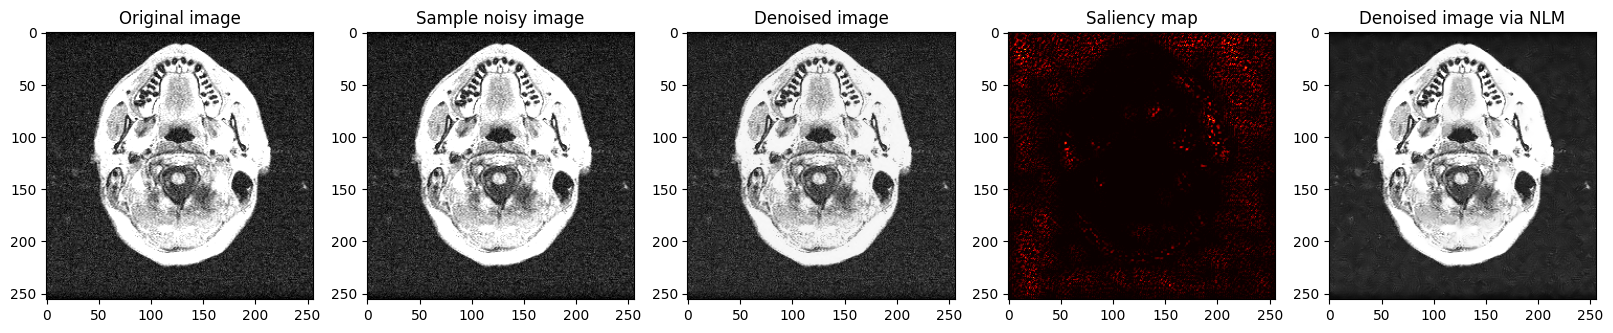

Finished Testing Session
Time elapsed in miliseconds:  139658.171875
Sigma:  0
Initial PSNR:  inf +- nan
Initial SSIM:  1.0 +- 0.0
Initial RMSE:  0.0 +- 0.0
Final PSNR:  44.60758 +- 1.04685
Final SSIM:  0.9901 +- 0.00262
Final RMSE:  0.01185 +- 0.00138
p-value PSNR:  nan
p-value RMSE:  0.0
NLM PSNR:  29.52033 +- 1.22019
NLM SSIM:  0.73733 +- 0.06478
NLM RMSE:  0.06748 +- 0.00922




In [23]:
dec2 = input("Do you want to test the model? (y/n): ")
if dec2.lower() == 'y':
    #load in latest saved model
    torch.cuda.empty_cache()
    network = torch.load('C:\\Users\\miker\\Downloads\\IXI-T1\\denoisenet.pth')  ### CHANGE THIS TO THE PATH OF THE MODEL SAVED ON YOUR PERSONAL COMPUTER
    network.to(device)

    #select the partitioned data folder
    partition_folder_path = tkinter_gui("Select the folder containing the partitioned data")
    part_occurences = partition_folder_path.count('partition')
    if part_occurences == 0:
        raise SyntaxError("No partitioned data found in the selected folder")
    elif part_occurences > 1:
        raise SyntaxError("Please select the root folder containing each partition folder (e.g. partition_0, partition1_,..., partition_n) and not the individual partition folders themselves")
    denoise_stats_container = {}
    nlm_stats_container = {}

    if "IXI" in partition_folder_path.upper() or "NYU" in partition_folder_path.upper():   ### THIS IS FOR SYNTHETIC DATA - CHANGE TO SEARCH FOR ANY KEYWORDS IN DATAPATH THAT MIGHT BE INDICATIVE OF HIGH-FIELD MRI DESTINED FOR SYNTHETIC NOISE CORRUPTION
        sigmas = [1,3,5,7,9]

        # test for each pre-defined gaussian sigma
        for sigma in sigmas:
            data_type = 's'
            print("Testing for sigma: ", sigma)
            model_denoise_perf, nlm_denoise_perf = test(network, partition_folder_path, anomaly_detection=False, device=device, partitions=1, d_type='synthetic', sigma_gauss=sigma)
            denoise_stats_container[sigma] = model_denoise_perf
            nlm_stats_container[sigma] = nlm_denoise_perf

    else:
        data_type = input("Enter the data type (e.g. s for synthetic data with noise-generation required, or r for real low-field data): ")
        #test at one pre-defined sigma
        if data_type.lower() == 's':
            sigmas = [1,3,5,7,9]
            # test for each pre-defined gaussian sigma
            for sigma in sigmas:
                data_type = 's'
                print("Testing for sigma: ", sigma)
                model_denoise_perf, nlm_denoise_perf = test(network, partition_folder_path, anomaly_detection=False, device=device, partitions=1, d_type='synthetic', sigma_gauss=sigma)
                denoise_stats_container[sigma] = model_denoise_perf
                nlm_stats_container[sigma] = nlm_denoise_perf
        #test with real data
        elif data_type.lower() == 'r':
            model_denoise_perf, nlm_denoise_perf = test(network, partition_folder_path, anomaly_detection=False, device=device, partitions=1, d_type='real', dec_save=True)
            denoise_stats_container[0] = model_denoise_perf
            nlm_stats_container[0] = nlm_denoise_perf

    test_values = {}

#print statistics for each sigma to allow evaluation of test performance
for sigma in denoise_stats_container:
    print("Sigma: ", sigma)
    init_psnr_mean = np.nanmean(denoise_stats_container[sigma]['psnr_init'])
    init_psnr_std = np.nanstd(denoise_stats_container[sigma]['psnr_init'])
    print("Initial PSNR: ", round(init_psnr_mean,5), "+-", round(init_psnr_std,5))
    init_ssim_mean = np.nanmean(denoise_stats_container[sigma]['ssim_init'])
    init_ssim_std = np.nanstd(denoise_stats_container[sigma]['ssim_init'])
    print("Initial SSIM: ", round(init_ssim_mean,5), "+-", round(init_ssim_std,5))
    init_rmse_mean = np.nanmean(denoise_stats_container[sigma]['rmse_init'])
    init_rmse_std = np.nanstd(denoise_stats_container[sigma]['rmse_init'])
    print("Initial RMSE: ", round(init_rmse_mean,5), "+-", round(init_rmse_std,5))
    final_psnr_mean = np.nanmean(denoise_stats_container[sigma]['psnr_final'])
    final_psnr_std = np.nanstd(denoise_stats_container[sigma]['psnr_final'])
    print("Final PSNR: ", round(final_psnr_mean,5), "+-", round(final_psnr_std,5))
    final_ssim_mean = np.nanmean(denoise_stats_container[sigma]['ssim_final'])
    final_ssim_std = np.nanstd(denoise_stats_container[sigma]['ssim_final'])
    print("Final SSIM: ", round(final_ssim_mean,5), "+-", round(final_ssim_std,5))
    final_rmse_mean = np.nanmean(denoise_stats_container[sigma]['rmse_final'])
    final_rmse_std = np.nanstd(denoise_stats_container[sigma]['rmse_final'])
    print("Final RMSE: ", round(final_rmse_mean,5), "+-", round(final_rmse_std,5))
    print("p-value PSNR: ", ttest_rel(denoise_stats_container[sigma]['psnr_init'], denoise_stats_container[sigma]['psnr_final'])[1])
    print("p-value RMSE: ", ttest_rel(denoise_stats_container[sigma]['rmse_init'], denoise_stats_container[sigma]['rmse_final'])[1])
    nlm_psnr_mean = np.nanmean(nlm_stats_container[sigma]['psnr_nlm'])
    nlm_psnr_std = np.nanstd(nlm_stats_container[sigma]['psnr_nlm'])
    print("NLM PSNR: ", round(nlm_psnr_mean,5), "+-", round(nlm_psnr_std,5))
    nlm_ssim_mean = np.nanmean(nlm_stats_container[sigma]['ssim_nlm'])
    nlm_ssim_std = np.nanstd(nlm_stats_container[sigma]['ssim_nlm'])
    print("NLM SSIM: ", round(nlm_ssim_mean,5), "+-", round(nlm_ssim_std,5))
    nlm_rmse_mean = np.nanmean(nlm_stats_container[sigma]['rmse_nlm'])
    nlm_rmse_std = np.nanstd(nlm_stats_container[sigma]['rmse_nlm'])
    print("NLM RMSE: ", round(nlm_rmse_mean,5), "+-", round(nlm_rmse_std,5))
    print("\n")
    test_values[sigma] = {"init_psnr_mean": init_psnr_mean, "init_psnr_std": init_psnr_std, "init_ssim_mean": init_ssim_mean, "init_ssim_std": init_ssim_std, "init_rmse_mean": init_rmse_mean, "init_rmse_std": init_rmse_std, "final_psnr_mean": final_psnr_mean, 
                          "final_psnr_std": final_psnr_std, "final_ssim_mean": final_ssim_mean, "final_ssim_std": final_ssim_std, "final_rmse_mean": final_rmse_mean, "final_rmse_std": final_rmse_std, "p-value_psnr": ttest_rel(denoise_stats_container[sigma]['psnr_init'], 
                           denoise_stats_container[sigma]['psnr_final'])[1], "p-value_rmse": ttest_rel(denoise_stats_container[sigma]['rmse_init'], denoise_stats_container[sigma]['rmse_final'])[1], "nlm_psnr_mean": nlm_psnr_mean, "nlm_psnr_std": nlm_psnr_std, 
                           "nlm_ssim_mean": nlm_ssim_mean, "nlm_ssim_std": nlm_ssim_std, "nlm_rmse_mean": nlm_rmse_mean, "nlm_rmse_std": nlm_rmse_std}
